# EnvBayes Notebook #2. Documenting a Bayesian Analysis

## Main Points
* A Bayesian analysis has a few additional reporting requirements that will be new to non-Bayesians.   
* This notebook is a general introduction to Bayesian reporting by following a simple example.
* Bayesian reporting requirements are well-established in the Bayesian community and can generally be produced in just a few lines of code.

## Introduction

EnvBayes Notebook #1 provided an Introduction to Bayesian Statistics for Environmental Science through the lens of a physical model, or data generating process. The Bayesian methodology a natural fit for environmental science, where most problems are grounded in well-understood physical and chemical processes.  

**However,** the environmental cleanup industry is heavily regulated, and Bayesian models can be unfamiliar and tricky.  Therefore, we need a standard template for presenting the results of a Bayesian analysis. Fortunately, John Kruschke recently published [*Bayesian Analysis Reporting Guidelines*](https://www.nature.com/articles/s41562-021-01177-7) (Kruschke, 2021) (BARG), cataloging the core components of a Bayesian report.  Based on his work, and considering the needs of the environmental industry, I have put together this stripped-down example.  Luckily, the Bayesian-specific components of the reporting guidelines have already been implemented in Python in Pymc and Arviz.

This notebook provides a cursory summary of the underlying concepts that support Bayesian techniques.  Two excellent resources for more detail are [*Statistical Rethinking*](https://xcelab.net/rm/statistical-rethinking/) (McElraith, 2020), and [*Bayesian Modeling and Computation in Python*](https://bayesiancomputationbook.com/welcome.html) (Martin, Kumar and Lao, 2022). 

## Outline of a Bayesian Analysis
Below is the outline adapted from the BARG.  For readability, I have reorganized Kruschke's checklist to present the core results up front, and the diagnostic checks in the back of the document.  The Bayesian scientist would need to do the diagnostic checks first, but the common reader would want the diagnostic checks in the back.     

**Main Text**
1. *Purpose and Background*
2. *Model Description*
    * Model equations
    * Prior distributions for input variables and rationale 
    * Form of the likelihood function for output variables and rationale
    * Complete model specification  
3. *Results*
    * Posterior distributions
    * Decision criteria, if relevant (e.g., Bayesian p-values)
4. *Discussion*

**Appendices**  
* A. *MCMC Diagnostics*  
    * MCMC chain convergence  
    * MCMC chain resolution  
* B. *Prior and Posterior Predictive Checks*  
    * Prior predictive checks  
    * Posterior predictive checks  
* C. *Sensitivity to Alternative Model Specifications*  
    * Impact of alternative priors  
    * Impact of other model choices  
* D. *Reproducibility*  
    * Project code, including data preprocessing, commented code, and documentation.  Jupyter Book does this for me 😀.    

### Graphical Depiction of the Outline

At the end of Notebook #1, I presented the following graphical depiction of Bayesian inference:  

![BayesianInference](images/BayesianInference.png)

Now let's mark it up to show where the information is presented in the report outline   

![DocumentationRoadmap](images/DocumentationRoadmap.png)

Appendix B needs it's own diagram out of the components of the previous diagram.  

![PredictiveChecks](images/PredictiveChecks.png)

The prior and posterior checks simulate data by running the model  forward, once with the prior distributions (starting distributions) and once with the posterior distributions (the results).

In the next sections, I will work through a bare-bones example with code in Python using the packages Pymc and Arviz.  I'll use the SEDCAM model presented in EnvBayes Notebook #1 on publically available sediment data from Puget Sound.  

## Section 1. Purpose
### Background
We want to understand the long-term trends on contaminant concentrations in sediment in Puget Sound, which impacts the health of the ecosystem and people who rely on the ecosystem.  In 2018, the Washington State Department of Ecology published [*Sediment Quality in Puget Sound: Changes in chemical contaminants and invertebrate communities at 10 sentinel stations, 1989–2015*](https://www.researchgate.net/publication/330689038_Sediment_Quality_in_Puget_Sound_Changes_in_chemical_contaminants_and_invertebrate_communities_at_10_sentinel_stations_1989-2015), which presented time trends for multiple contaminants in surface sediment over time.  For illustrative purpose, I pulled data from 2000-2016 for benzo(a)pyrene (BaP) from Station 3 in the Straight of Georgia in the north end of Puget Sound.  

BaP is a heavy carcinogenic polycyclic aromatic hydrocarbon that is persistent in the environment with very low biodegradation rates.  It is a concern to human health, particularly to those eating shellfish.  A source of BaP is combustion, therefore there are ongoing, low-level inputs of BaP to sediment from general urban activities.  Due to these characteristics, I thought the dataset would provide a nice example for this analysis.  Note that there are nuances to this dataset that I'm leaving out of this analysis, so that I can focus on the Bayesian modeling.   

Import and Plot Data 

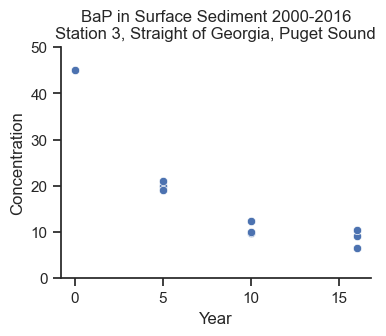

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import numpy as np
import datetime
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
import pymc as pm
import arviz as az
pd.set_option('display.colheader_justify', 'center')

data = pd.read_csv('data/Straight_Georgia_BaP_PSAMP_Data.csv')
data.Date = pd.to_datetime(data.Date)
data['Year'] = data.Date.dt.year.astype(int)
data.Year = data.Year - data.Year.min()

#plot
fig, ax = plt.subplots(figsize=(4,3))
sns.scatterplot(data=data, x='Year', y='Concentration', ax=ax)
ax.set_ylim(0,50)
ax.set_title('BaP in Surface Sediment 2000-2016\nStation 3, Straight of Georgia, Puget Sound');

### Purpose
The purpose of this analysis is to: 
* Estimate future concentrations of BaP at the location and the uncertainty in the estimate.
* Link the estimate to physical processes, including the rate of depositing sediment and the concentration of BaP in depositing sediment.  

### Why Bayes?
A Bayesian approach was selected for this analysis because it accommodates non-linear modeling (in this case, exponential decay to an asymptote), transparently incorporates prior knowledge, and provides uncertainty estimates for all model parameters.

## Section 2. Model Description
### Physical Model
The SEDCAM model ([Jacobs et al. 1988](https://www.eopugetsound.org/sites/default/files/features/resources/PugetSoundResearch1988Vol2Optimized_0.pdf)) is an exponential decay equation that predicts the future concentration of a contaminant in sediment from a starting concentration, a depositing concentration, a deposition rate and a mixing depth in sediment.  The SEDCAM model is reasonable for modeling BaP in this location because it captures the general physical characteristics of sediments in the area (historical contaminant releases, followed by deposition and mixing), and because the data appear to follow the trend of exponential decay to an asymptote.  The model assumes a constant deposition rate and depositing concentration over time, which is a reasonable starting place for this analysis.  The model equation is as follows:

$$
C_t = C_d(1-e^{-Rt/B}) + C_0e^{-Rt/B}
$$

Where:  
$C_t = $ the surface sediment contaminant concentration at time $t$   
$C_d = $ the contaminant concentration in depositing sediment  
$C_0 = $ the starting contaminant concentration  
$R = $ the sedimentation rate  
$t = $ time  
$B = $ depth of the biologically active zone  

### Prior Distributions for Input Variables
#### Background
The selection of priors can be a stumbling block for Bayesian analysis, because of varying opinion on the approach to establishing prior probabilities.  However, a systematic approach to selecting priors can be straight forward to implement, and the selection of different prior probabilities can be readily compared.  In many cases, the width of the priors will not impact the results very much.      

Approaches to prior specification can be summarized as the following: 
* *Informative.*  Informative priors use existing information and past studies to provide narrow probability distributions to the model.  Informative priors may have a large impact the results of the analysis.   
* *Weakly informative.* Weakly informative priors use existing information to provide wide probability distributions to the model.  Weakly informative priors are considered the default choice in many applications.  Packages that automatically generate prior distributions (e.g., [rstanarm](https://mc-stan.org/rstanarm/) and [Bambi](https://bambinos.github.io/bambi/main/index.html)) use weakly informative priors.  Weakly informative priors will minimally impact the results of the analysis, so that the data can speak for themselves.      
* *Uninformative.*  Uninformative priors are used to maximize the skepticism that is brought to the analysis and can be used to replicate frequentist results for some models.  However, it can be challenging to implement uninformative priors for many models because prior predictions are not in the ballpark of the data.     
* *Adaptive.* Adaptive priors are used in hierarchical models for categorical data, and allow data to share information across categories.  Adaptive priors are the default method for assigning priors for categorical data (depending on the goals of the study).    

Overall, the approach in this notebook is to use available data to develop prior distributions, but keep the analysis very simple.  Think of this as a "back-of-the-envelope meta-analysis."  Here are some additional principles for development of priors: 

* Use informative priors for parameters with a lot of background information (e.g., replicating a past study), or for parameters that should be held relatively constant in the model.  
* Use weakly informative priors for parameters with more uncertainty, or parameters particular interest in the analysis.  
* Use adaptive priors for categorical data when applicable (this notebook does not use adaptive priors). 
* Run the model with different priors to compare the results.  If the two results are similar, then prior specification isn't worth stressing over.  
* Use the model to help select priors.  Prior predictive checks can help to demonstrate whether priors are in the ballpark, and the posterior MCMC inference algorithm will often produce errors when priors are poorly specified.   

The rest of this section documents the selection of priors for the four input variables, $C_d$, $C_0$, $R$, and $B$.

#### $C_d$ and $C_0$
Prior distributions for $C_d$ and $C_0$ are based on summary statistics from a back-of-the-envelope meta-analysis.  BaP data from the longitudinal studies within all of Puget Sound (study IDs PSAMP_LT and PSEMP_LT in Washington State Department of Ecology's EIM database) were downloaded and aggregated without adjusting for date, location, detection limits, etc.  The resulting dataset had 292 samples with a mean of 136 ug/kg and a standard deviation of 347 ug/kg, which will be the mean and standard deviation of a normal prior distribution.  Both $C_d$ and $C_0$ will use the same prior so that differences in the two values will be based on the data only (we will not make a prior assumption that concentrations are increasing or decreasing).  We will also truncate the distribution at 0 to enforce positive-only results.    

#### $R$
The prior deposition rates, $R$, known to be around 1 cm/year in central Puget Sound.  To ground the prior in empirical data, the historical study documented in [Lavelle et. al. 1986](https://www.pmel.noaa.gov/pubs/PDF/lave732/lave732.pdf) is referenced, which found a mean deposition rate of 1.5 cm/year with a standard deviation of about 1.2 cm/year in 25 locations.  This wide range of potential deposition rates from multiple areas of Puget Sound is considered weakly informative.  We use a truncated normal distribution to enforce positive-only results.    

#### $B$
Finally, 10 cm is the widely established default bioturbation depth ($B$) in Puget Sound (e.g., [Ecology 2021](https://apps.ecology.wa.gov/publications/documents/1209057.pdf)), so we will give a tight bound on the prior with normal distribution with a mean of 10 cm and a standard deviation of 1 cm.  This is an informative prior distribution because of the relative narrowness of the distribution.    

### Likelihood Function for Output Variable $C_t$
The likelihood function represents the error (i.e., noise or spread) of the measured $C_t$ around the SEDCAM prediction for $C_t$.  

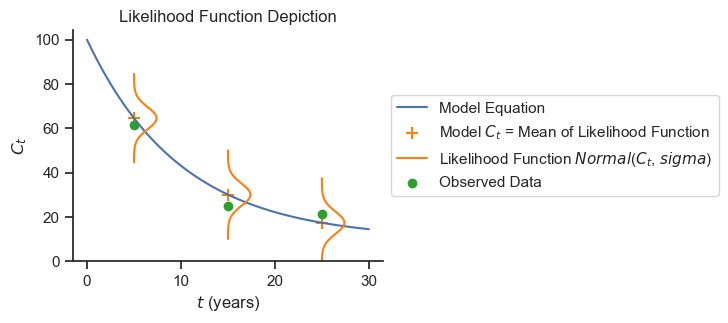

In [2]:
def sedcam(Cd, C0, R, t, B):
    return Cd * (1 - np.exp(-R*t/B)) + C0 * np.exp(-R*t/B)

#Specify variable values for plotting. 
Cd = 10                     # ug/kg contaminant
C0 = 100                    # ug/kg contaminant
R = 1                       # cm/year
B = 10                      # cm
ts = np.linspace(0,30,100)  # years (0-30 in 100 increments)


colors = plt.get_cmap("tab10").colors

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(ts, sedcam(Cd, C0, R, ts, B), label='Model Equation')
ax.set_ylim(0)
ax.set_xlabel('$t$ (years)')
ax.set_ylabel('$C_t$')
ax.set_title('Likelihood Function Depiction')

coverage = 40
sigma = 5
height_multiplier = 30
y = np.linspace(-coverage/2, coverage/2, 100)
x = st.norm(0,sigma).pdf(y) * height_multiplier

t = 5
y_offset = sedcam(Cd, C0, R, t, B)
ax.scatter(t, y_offset, marker='+', s=80, label='Model $C_t$ = Mean of Likelihood Function', color=colors[1] )
ax.plot(x+t,y+y_offset, label='Likelihood Function ${Normal}$($C_t$, $sigma$)', color=colors[1])
ax.scatter(t, y_offset-3, label='Observed Data' ,color=colors[2])

t = 15
y_offset = sedcam(Cd, C0, R, t, B)
ax.plot(x+t,y+y_offset, color=colors[1])
ax.scatter(t, y_offset, marker='+', s=80,  color=colors[1])
ax.scatter(t, y_offset-5,color=colors[2])

t = 25
y_offset = sedcam(Cd, C0, R, t, B)
ax.plot(x+t,y+y_offset, color=colors[1])
ax.scatter(t, y_offset, marker='+', s=80,  color=colors[1])
ax.scatter(t, y_offset+4,color=colors[2])

ax.legend(loc='center left', bbox_to_anchor=(1,.5));

For this analysis, we will use a normally distributed likelihood centered on the SEDCAM model prediction and with a standard deviation determined by the model.  A normal distribution is used because the data do not appear highly skewed and outliers do not appear to be present.  The normal distribution is also consistent with the common least-squares approach to model fitting.    

The standard deviation of the likelihood function will be determined by the model, and start with a weakly informative prior of a half-normal distribution centered on 0 with a standard deviation of 347 ug/kg, consistent with the variance in BaP values in longitudinal Puget Sound studies.    

### Complete Model Specification
The complete model specification in Pymc is as follows: 

In [3]:
with pm.Model() as sedcam_bayes:
    # Data
    t_obs = pm.MutableData('t_obs', data.Year.values)
    Ct_obs = pm.MutableData('Ct_obs', data.Concentration.values)
    
    # Priors
    Cd = pm.TruncatedNormal('Cd', mu=136, sigma=347, lower=0)
    C0 = pm.TruncatedNormal('C0', mu=136, sigma=347, lower=0)
    R = pm.TruncatedNormal('R', mu=1.5, sigma=1.2, lower=0)
    B = pm.TruncatedNormal('B', mu=10, sigma=1, lower=0)
    
    # SEDCAM Prediction
    Ct = pm.Deterministic('Ct', Cd * (1 - pm.math.exp(-R*t_obs/B)) + C0 * pm.math.exp(-R*t_obs/B))

    # Likelihood
    sigma = pm.HalfNormal('sigma', sigma=347)
    Ct_modeled = pm.Normal('Ct_modeled', mu=Ct, sigma=sigma, observed=Ct_obs)
sedcam_bayes

        Cd ~ TruncatedNormal(136, 347, 0, inf)
        C0 ~ TruncatedNormal(136, 347, 0, inf)
         R ~ TruncatedNormal(1.5, 1.2, 0, inf)
         B ~ TruncatedNormal(10, 1, 0, inf)
     sigma ~ N**+(0, 347)
        Ct ~ Deterministic(f(C0, Cd, B, R))
Ct_modeled ~ N(Ct, sigma)

Pymc provides a graphical representation of the model as well.    

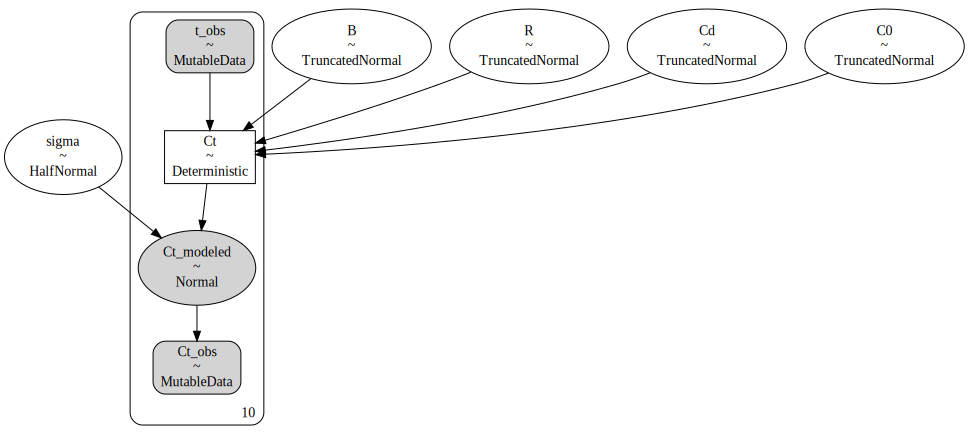

In [4]:
pm.model_to_graphviz(sedcam_bayes)

## Section 3. Results

Fit the model.

In [5]:
with sedcam_bayes:
    prior = pm.sample_prior_predictive(500)
    trace = pm.sample(target_accept=.9)
    post_pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Cd, C0, R, B, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.


### Posterior
The posterior results are the meat of the analysis.  Let's plot 50 samples from the posterior distribution to get an idea of the spread of results.  

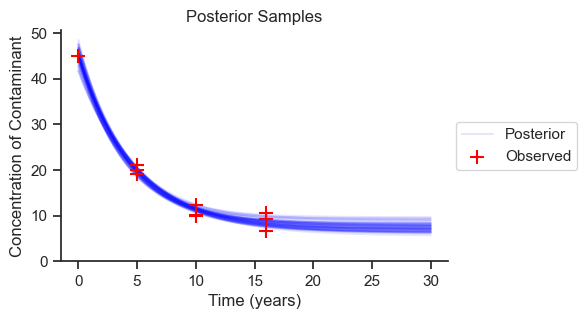

In [6]:
def sedcam(Cd, C0, R, t, B):
    return Cd * (1 - np.exp(-R*t/B)) + C0 * np.exp(-R*t/B)

ts = np.linspace(0,30,100)
Cd = trace.posterior['Cd'].values.flatten()
R = trace.posterior['R'].values.flatten()
C0 = trace.posterior['C0'].values.flatten()
B = trace.posterior['B'].values.flatten()

fig, ax = plt.subplots(figsize=(5,3))
for i in range(50):
    ax.plot(ts, sedcam(Cd[i], C0[i], R[i], ts, B[i]), color='blue', alpha=.1, label='Posterior')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0)
ax.scatter(data.Year, data.Concentration, marker='+', s=100, label = 'Observed', 
         color='red', zorder=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], loc='center left', bbox_to_anchor=(1,.5))
ax.set_title('Posterior Samples');

The range of predictions is reasonable based on the data.  We can see how the predictions become less certain the further we extrapolate into the future, as we go beyond the observed data.  Now we will look at the probability distributions for each of the parameters.  

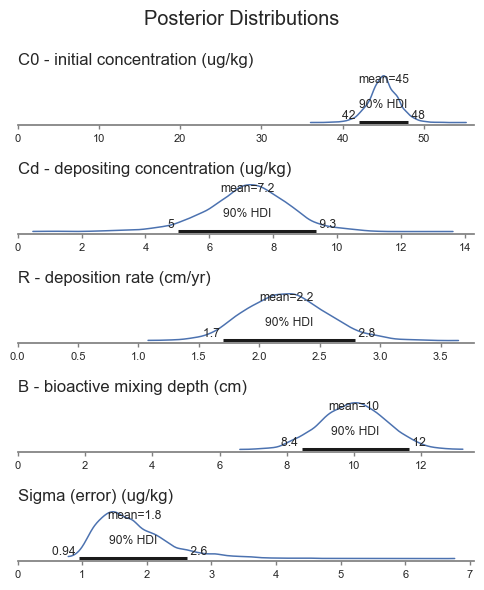

In [7]:
labels = ['C0 - initial concentration (ug/kg)',
            'Cd - depositing concentration (ug/kg)', 
            'R - deposition rate (cm/yr)',  
            'B - bioactive mixing depth (cm)', 
            'Sigma (error) (ug/kg)']
var_names=[ 'C0', 'Cd',  'R', 'B', 'sigma']
axes = az.plot_posterior(trace, figsize = (5,6), hdi_prob=.9,
        textsize=8,
        var_names=var_names, grid=(len(var_names), 1))
for label, ax in zip(labels, axes):
    ax.set_xlim(0)
    ax.set_title('')
    ax.set_title(label, loc='left')
plt.suptitle('Posterior Distributions')
plt.tight_layout();

The plots present the posterior probability distributions for each parameter, highlighting the mean and the 90% highest density interval.  

The results are generally what we would expect based on the data.  Note that $B$ did not change much based on the data, because the prior was more informative than the priors for the other parameters.  The other parameters, which had weakly informative prior, had larger differences between the prior and posterior.

Here is the same information in tabular form: 

In [8]:
az.summary(trace, hdi_prob=.9, var_names=var_names).iloc[:, :4].rename(index=dict(zip(var_names, labels))).round(1)

,mean,sd,hdi_5%,hdi_95%
C0 - initial concentration (ug/kg),45.0,1.9,42.0,48.0
Cd - depositing concentration (ug/kg),7.2,1.4,5.0,9.4
R - deposition rate (cm/yr),2.2,0.3,1.7,2.8
B - bioactive mixing depth (cm),10.0,1.0,8.4,11.6
Sigma (error) (ug/kg),1.8,0.6,0.9,2.6


It is also worth noting that the posterior distributions are correlated.  Logically, we know this should be true.  For example, suppose we have a large rate of decline in concentration.  A really low depositing concentration $C_d$ could achieve this, and it would not require a large deposition rate $R$.  In contrast, a higher $C_d$ would need a larger deposition rate $R$ to get the same rate of decline.  So our reasoning tells us that $C_d$ and $R$ are positively correlated.  Let's see if the Bayesian analysis figured that out:       

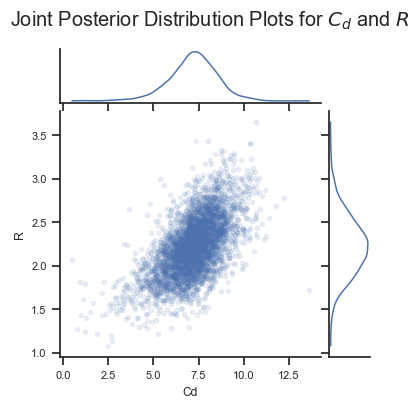

In [9]:
az.plot_pair(trace, var_names=['Cd', 'R'], marginals=True, 
            scatter_kwargs={'alpha':.1}, figsize=(4,4))
plt.suptitle('Joint Posterior Distribution Plots for $C_d$ and $R$');

Yes it did!  This information could be useful in understanding uncertainties in the analysis.  For example, if we are skeptical of very high values of $R$, then we should likewise be skeptical of high values of $C_d$.

### Year 30 Prediction
Recall that one of the purposes of the analysis was to estimate the predicted concentrations in the future.  We can estimate the future mean concentrations using the posterior, and the future distribution of sample data using posterior predictions for year 30.   

Posterior predictive sample at year 30.  

In [10]:
# set year to 30
sedcam_bayes.set_data('t_obs', [30])
# simulate data
with sedcam_bayes:
    post_pred_30 = pm.sample_posterior_predictive(trace)

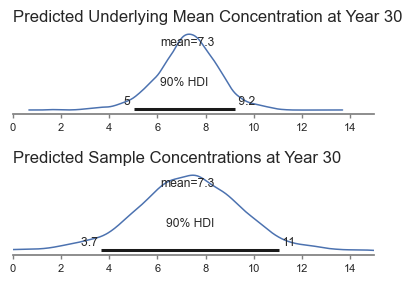

In [11]:
fig, axes = plt.subplots(2,1,figsize=(4,3))
ax = axes[0]
az.plot_posterior(sedcam(Cd, C0, R, 30, B), ax=ax,
             textsize=8, hdi_prob=.9)
ax.set_title('')
ax.set_title('Predicted Underlying Mean Concentration at Year 30', loc='left')

ax = axes[1]
az.plot_posterior(post_pred_30.posterior_predictive['Ct_modeled'].values.flatten(),
            ax=ax,  textsize=8, hdi_prob=.9)
ax.set_title('')
ax.set_title('Predicted Sample Concentrations at Year 30', loc='left')
for ax in axes:
    ax.set_xlim(0,15)
plt.tight_layout();

These results make intuitive sense.  The mean of both distributions is the same, and the range in sample concentrations would be wider than the range in underlying mean concentrations.  

## Section 4. Discussion
The Bayesian methodology was able to provide coherent uncertainty estimates for all model parameters, given the data.  There are lots of ways to adapt this model to answer additional questions, include other chemicals, other locations, or longer time frames, incorporate changing conditions over time, etc.

The next sections, the "Appendices," dig into model diagnostics and model checking to demonstrate that these results were reliable from a modeling standpoint.  

## Appendix A. MCMC Diagnostics

The Python package Arviz provides a bunch of functions for performing MCMC diagnostics.  A great resource to learn more is *Bayesian Modeling and Computation in Python* [Chapter 2](https://bayesiancomputationbook.com/markdown/chp_02.html).  In this appendix, I'll present and briefly introduce the most common diagnostic tools. 

### MCMC Chain Convergence
The way that Pymc estimates the posterior probability distribution for each parameter is by sampling the distribution many times (e.g., ~8000).  The MCMC sampler doesn't know the probability of the whole distribution, but it does know the relative probability (and the gradient) in each step along the way.  With this information, the cleverly-designed MCMC algorithm will hang out in areas with higher probability more than areas with lower probability - in the exact proportion to their comparative probabilities!  Once the sampling is complete, then entire sample (i.e., the "trace," or the "long list of locations the MCMC algorithm explored") defines the approximate posterior probability.  

Because there is some degree of randomness in the MCMC algorithm, Pymc will will run it multiple times so that we can check that we are getting the same results each time (i.e., for each chain). The trace plot plots the chains separately so we can see if they line up.      

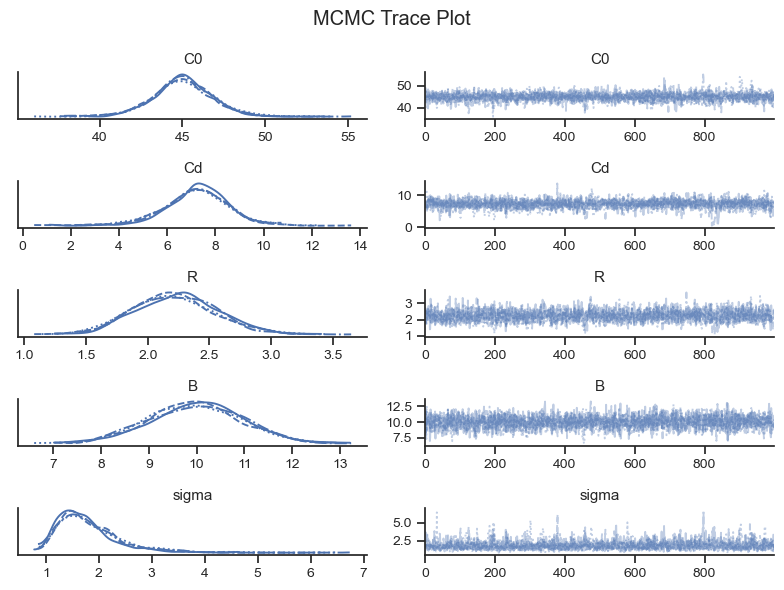

In [12]:
az.plot_trace(trace, var_names=var_names, figsize=(8,6))
plt.suptitle('MCMC Trace Plot')
plt.tight_layout();

The left column of the trace plots show the final probability distribution for each chain.  As long as they line up fairly well, then the MCMC sampler "converged."  *Bayesian Modeling and Computation in Python* [Section 2.4.4](https://bayesiancomputationbook.com/markdown/chp_02.html) shows some examples of trace plots for inferences that have not converged. 

The right column of the trace plot shows the MCMC chains over time.  They should look like white noise, or fuzzy caterpillars.  These plots are good for identifying if a chain got stuck along the way (which would show as a horizontal line), or another pathology.   

On each subplot you might see tick marks on the x-axis.  These are "divergences" where the MCMC algorithm gives an error message when it gets an unexpected result.  Divergences can help to diagnose modeling errors and potential remedies.  However, having a few divergences does not indicate that the inference failed, provided the traces look good otherwise. 

Convergence metrics are also provided by the Arviz package.  `r_hat` measures the convergence and should generally be 1.01 or below, according to rule of thumb.     

In [13]:
az.summary(trace, hdi_prob=.9, var_names=var_names)[['r_hat']].round(2)

,r_hat
C0,1.00
Cd,1.00
R,1.00
B,1.00
sigma,1.01


Based on the visual and tabular diagnostic checks, the MCMC chains converged.  

### MCMC Chain Resolution
The MCMC algorithm can get stuck in certain areas of the parameter space, and might not be able to explore the entire parameter space.  The common metric to check for MCMC chain resolution is effective sample size (ESS), which provide a measure for the effective number of samples in the trace by examining the autocorrelation among MCMC samples.  Again, more information in [*Bayesian Modeling and Computation in Python*](https://bayesiancomputationbook.com/markdown/chp_02.html).  A general rule of thumb is that more than 400 samples are needed to have a good characterization of the posterior distribution. 

The tail of the distributions take longer to characterize than the center of the distributions, because the sampler will hang out less in the tail than in the center.  Therefore, Arviz provides values for ESS in the entire distribution (bulk) and in the tails only (based on the 5th and 95th percentiles).  

In [14]:
az.summary(trace, hdi_prob=.9, var_names=var_names)[['ess_bulk', 'ess_tail']]

,ess_bulk,ess_tail
C0,2114.0,1747.0
Cd,1670.0,1077.0
R,1447.0,1403.0
B,2262.0,2089.0
sigma,1604.0,1596.0


Based on the table above, the MCMC chain resolution is sufficient.  

## Appendix B. Prior and Posterior Predictive Checks

Prior and posterior predictive checks are also a meaningful way to assess the behavior of a Bayesian model.  This section provides graphical results for prior and posterior predictive checks.  

### Prior Predictive Check
The prior predictive sample is a forward simulation on the prior distributions without inference on the observed data. The purpose of the prior predictive check is to see that the prior distributions are in the right ballpark and to understand which direction the choice of priors could be biasing our results.  

In the following figure, I'll plot 50 samples from the prior predictive check and 50 samples from the posterior to compare.  

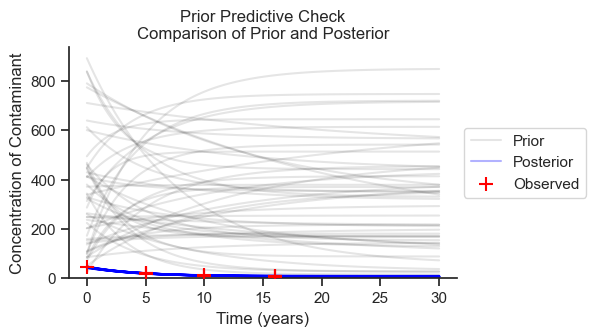

In [15]:
Cd0 = prior.prior['Cd'].values.flatten()
R0 = prior.prior['R'].values.flatten()
C00 = prior.prior['C0'].values.flatten()
B0 = prior.prior['B'].values.flatten()


fig, ax = plt.subplots(figsize=(5,3))
for i in range(50):
    ax.plot(ts, sedcam(Cd0[i], C00[i], R0[i], ts, B0[i]), color='black', alpha=.1, label='Prior')
    ax.plot(ts, sedcam(Cd[i], C0[i], R[i], ts, B[i]), color='blue', alpha=.3, label='Posterior')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0)
ax.scatter(data.Year, data.Concentration, marker='+', s=100, label = 'Observed', 
         color='red', zorder=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='center left', bbox_to_anchor=(1,.5))
ax.set_title('Prior Predictive Check\nComparison of Prior and Posterior');

The priors are generally in the ballpark, but much higher than the posterior. Therefore, if the priors are nudging the results in a particular direction, they are nudging the results toward higher concentrations, more variance, and less decline in concentration. 

### Posterior Predictive Checks
Another benefit of Bayesian modelling is that the fit model can be used to generate synthetic datasets, which can be  visually compared to the observed dataset to see if the characteristics are similar.  The following plot show several draws from the posterior predictive sample.  

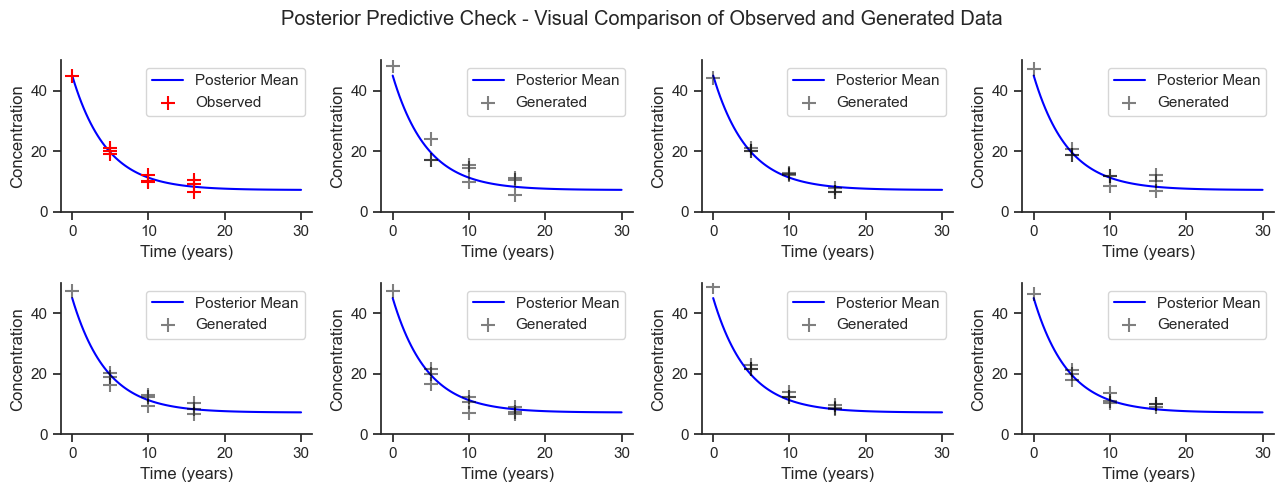

In [16]:
fig, axes = plt.subplots(2,4,figsize=(13,5))
idxs = [0, 100, 200, 300, 400, 500, 600, 700, 800]
for idx, ax in zip(idxs, axes.flatten()):
    ax.plot(ts, sedcam(Cd.mean(), C0.mean(), R.mean(), ts, B.mean()), 
            color='blue', alpha=1, label='Posterior Mean')
    ax.set_xlabel('Time (years)')
    ax.set_ylabel('Concentration')
    ax.set_ylim(0)
    if idx==0:
        ax.scatter(data.Year, data.Concentration, marker='+', s=100, label = 'Observed', 
                color='red', zorder=1000)
        #ax.set_title('Observed')
    else:
        ax.scatter(data.Year,
                post_pred.posterior_predictive['Ct_modeled'][0][idx].values,
                marker='+', s=100, label = 'Generated', alpha=.5,
                color='black', zorder=1000)
        #ax.set_title('Generated')
    ax.set_ylim(0,50)
    ax.legend()

plt.suptitle('Posterior Predictive Check - Visual Comparison of Observed and Generated Data')
plt.tight_layout();

Based on this visual check, the model is generating reasonable data. 

To check the likelihood shape, we will plot the observed data and the posterior predictive samples as residual errors against the mean model predictions.  

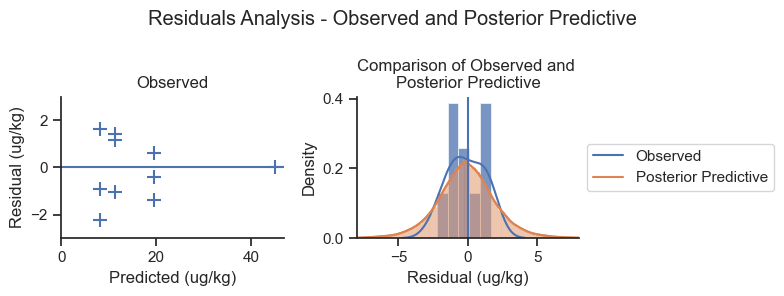

In [17]:
mean_pred =  sedcam(Cd.mean(), C0.mean(), R.mean(), data.Year, B.mean())
post_pred_resid = (mean_pred.values.reshape(1,10) - 
                   post_pred.posterior_predictive['Ct_modeled'].values.reshape(4000,10))

fig, axes = plt.subplots(1,2, figsize=(8,3))
ax = axes[0]
ax.scatter(x = mean_pred, y = mean_pred - data.Concentration, 
           marker='+', s=100, label = 'Observed')
ax.axhline(0)
ax.set_xlabel('Predicted (ug/kg)')
ax.set_xlim(0)
ax.set_ylim(-3, 3)
ax.set_ylabel('Residual (ug/kg)')
ax.set_title('Observed')
ax = axes[1]
sns.kdeplot(mean_pred - data.Concentration,  ax=ax, label='Observed')
sns.kdeplot(post_pred_resid.flatten(), ax=ax, label='Posterior Predictive')
sns.histplot(mean_pred - data.Concentration, stat='density', ax=ax)
sns.histplot(post_pred_resid.flatten(), kde=True, stat='density', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
ax.set_xlabel('Residual (ug/kg)')
ax.set_title('Comparison of Observed and \nPosterior Predictive')
ax.set_xlim(-8, 8)
ax.axvline(0)
plt.suptitle('Residuals Analysis - Observed and Posterior Predictive')
plt.tight_layout();

The left-hand plot shows that the model is not systematically biased relative to the magnitude of the prediction.  The right-hand plot shows that the posterior predictive distribution is a reasonable shape compared to the observed data.  The posterior predictive distribution is systematically wider than the observed data based on the plot on the right, but this is reasonable for a small dataset (n=10).   

## Appendix C. Sensitivity to Alternative Model Specifications
There are infinitely many models that could be used in any situation, and the selection of model specification will rely on the judgement of the researcher.  However, it may be useful to run alternative specifications of the model to present side-by-side with the final selected model for reference.  This appendix will first rerun the model with a different prior specification for comparison.  Next, this appendix will run a completely different model and use the common metrics for comparing models.  

### Informative Priors
The prior predictive check showed that the prior distributions resulted in concentrations that were much higher than the observed data.  If we have prior reason to believe that concentrations are declining, we can use informative priors with higher concentrations for $C_d$ compared to $C_0$, and establish both of them closer to the expected concentrations.      

In [18]:
with pm.Model() as sedcam_bayes:
    # Data
    t_obs = pm.MutableData('t_obs', data.Year.values)
    Ct_obs = pm.MutableData('Ct_obs', data.Concentration.values)
    
    # Priors
    Cd = pm.TruncatedNormal('Cd', mu=10, sigma=5, lower=0)
    C0 = pm.TruncatedNormal('C0', mu=50, sigma=10, lower=0)
    R = pm.TruncatedNormal('R', mu=1.5, sigma=1.2, lower=0)
    B = pm.TruncatedNormal('B', mu=10, sigma=1, lower=0)
    
    # Model Prediction
    Ct = pm.Deterministic('Ct', Cd * (1 - pm.math.exp(-R*t_obs/B)) + C0 * pm.math.exp(-R*t_obs/B))

    # Likelihood
    sigma = pm.HalfNormal('sigma', 2)
    Ct_modeled = pm.Normal('Ct_modeled', mu=Ct, sigma=sigma, observed=Ct_obs)
sedcam_bayes

        Cd ~ TruncatedNormal(10, 5, 0, inf)
        C0 ~ TruncatedNormal(50, 10, 0, inf)
         R ~ TruncatedNormal(1.5, 1.2, 0, inf)
         B ~ TruncatedNormal(10, 1, 0, inf)
     sigma ~ N**+(0, 2)
        Ct ~ Deterministic(f(C0, Cd, B, R))
Ct_modeled ~ N(Ct, sigma)

In [19]:
with sedcam_bayes:
    prior_informative = pm.sample_prior_predictive(500)
    trace_informative = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Cd, C0, R, B, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 123 seconds.


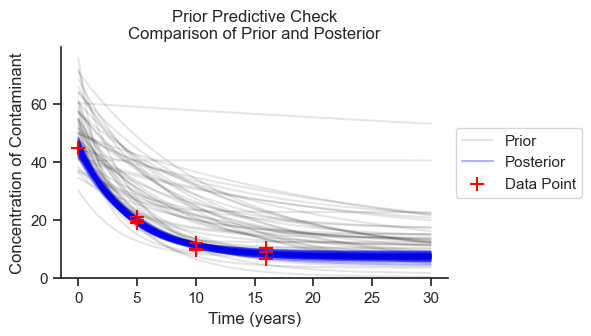

In [20]:
ts = np.linspace(0,30,100)
Cd0 = prior_informative.prior['Cd'].values.flatten()
R0 = prior_informative.prior['R'].values.flatten()
C00 = prior_informative.prior['C0'].values.flatten()
B0 = prior_informative.prior['B'].values.flatten()
Cd = trace_informative.posterior['Cd'].values.flatten()
R = trace_informative.posterior['R'].values.flatten()
C0 = trace_informative.posterior['C0'].values.flatten()
B = trace_informative.posterior['B'].values.flatten()

fig, ax = plt.subplots(figsize=(5,3))
for i in range(50):
    ax.plot(ts, sedcam(Cd0[i], C00[i], R0[i], ts, B0[i]), color='black', alpha=.1, label='Prior')
    ax.plot(ts, sedcam(Cd[i], C0[i], R[i], ts, B[i]), color='blue', alpha=.3, label='Posterior')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0)
ax.scatter(data.Year, data.Concentration, marker='+', s=100, label = 'Data Point', 
         color='red', zorder=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-3:], labels[-3:], loc='center left', bbox_to_anchor=(1,.5))
ax.set_title('Prior Predictive Check\nComparison of Prior and Posterior');

Informative priors are closer to the observed trend and are less biased than the weakly informative priors.  Now, let's compare posteriors:   

In [21]:
labels = ['C0 - initial concentration (ug/kg)',
            'Cd - depositing concentration (ug/kg)', 
            'R - deposition rate (cm/yr)',  
            'B - bioactive mixing depth (cm)', 
            'Sigma (error) (ug/kg)']
cols=['mean', 'hdi_5%', 'hdi_95%']
weakly_informative = az.summary(trace, hdi_prob=.9, var_names=var_names)[ cols ].rename(index=dict(zip(var_names, labels)))
informative = az.summary(trace_informative, hdi_prob=.9, var_names=var_names)[ cols].rename(index=dict(zip(var_names, labels)))
pct_change = (-weakly_informative + informative)/weakly_informative*100
weakly_informative.columns = pd.MultiIndex.from_product([['With Weakly Informative Priors (First Model)'], weakly_informative.columns])
informative.columns = pd.MultiIndex.from_product([['With Informative Priors (Second Model)'], informative.columns])
pct_change.columns = pd.MultiIndex.from_product([['Percent Change (First Model to Second Model)'], pct_change.columns])
pd.concat([weakly_informative, informative, pct_change], axis=1).round(1)

With Weakly Informative Priors (First Model)  \
                                                          mean                       
C0 - initial concentration (ug/kg)                        45.0                       
Cd - depositing concentration (ug/kg)                      7.2                       
R - deposition rate (cm/yr)                                2.2                       
B - bioactive mixing depth (cm)                           10.0                       
Sigma (error) (ug/kg)                                      1.8                       

                                                      \
                                      hdi_5% hdi_95%   
C0 - initial concentration (ug/kg)     42.0    48.0    
Cd - depositing concentration (ug/kg)   5.0     9.4    
R - deposition rate (cm/yr)             1.7     2.8    
B - bioactive mixing depth (cm)         8.4    11.6    
Sigma (error) (ug/kg)                   0.9     2.6    

                                      With Informative Priors (Second Model)  \
                                                       mean                    
C0 - initial concentration (ug/kg)                     45.2                    
Cd - depositing concentration (ug/kg)                   7.4                    
R - deposition rate (cm/yr)                             2.3                    
B - bioactive mixing depth (cm)                         9.9                    
Sigma (error) (ug/kg)                                   1.7                    

                                                      \
                                      hdi_5% hdi_95%   
C0 - initial concentration (ug/kg)     42.6    48.0    
Cd - depositing concentration (ug/kg)   5.6     9.4    
R - deposition rate (cm/yr)             1.7     2.8    
B - bioactive mixing depth (cm)         8.4    11.6    
Sigma (error) (ug/kg)                   1.0     2.3    

                                      Percent Change (First Model to Second Model)  \
                                                          mean                       
C0 - initial concentration (ug/kg)                         0.5                       
Cd - depositing concentration (ug/kg)                      2.6                       
R - deposition rate (cm/yr)                                1.2                       
B - bioactive mixing depth (cm)                           -0.3                       
Sigma (error) (ug/kg)                                     -8.8                       

                                                      
                                      hdi_5% hdi_95%  
C0 - initial concentration (ug/kg)      1.4    -0.0   
Cd - depositing concentration (ug/kg)  11.9     0.4   
R - deposition rate (cm/yr)             2.8     0.9   
B - bioactive mixing depth (cm)        -0.2     0.1   
Sigma (error) (ug/kg)                   2.2   -11.4

The informative priors tightened up the posterior distributions very slightly, which is considered to be in the noise of the overall analysis.    

### Comparison to a Linear Model

The Bayesian community also has well-established methods for comparing model by using cross-validation.  For illustrative purposes, I'll compare the SEDCAM model to a linear model with weakly informative priors.   

In [22]:
with pm.Model() as linear_model:
    # Data
    t_obs = pm.MutableData('t_obs', data.Year.values)
    Ct_obs = pm.MutableData('Ct_obs', data.Concentration.values)
    
    # Priors
    slope = pm.Normal('slope', mu=0, sigma=20)
    C0 = pm.TruncatedNormal('C0', mu=136, sigma=347, lower=0)
    
    # Model Prediction
    Ct = pm.Deterministic('Ct', C0 + slope * t_obs)

    # Likelihood
    sigma = pm.HalfNormal('sigma', 347)
    Ct_modeled = pm.Normal('Ct_modeled', mu=Ct, sigma=sigma, observed=Ct_obs)
linear_model

     slope ~ N(0, 20)
        C0 ~ TruncatedNormal(136, 347, 0, inf)
     sigma ~ N**+(0, 347)
        Ct ~ Deterministic(f(C0, slope))
Ct_modeled ~ N(Ct, sigma)

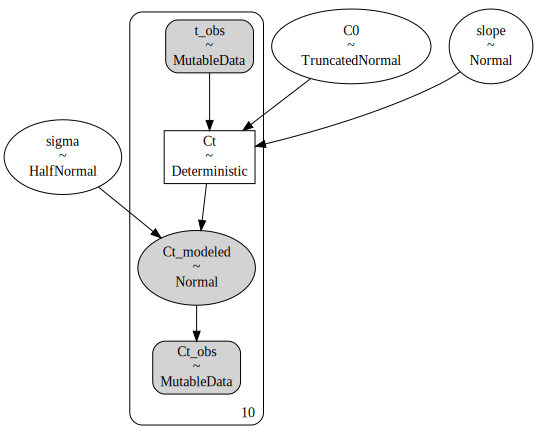

In [23]:
pm.model_to_graphviz(linear_model)

In [24]:
with linear_model:
    prior_linear = pm.sample_prior_predictive(500)
    trace_linear = pm.sample(target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, C0, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 157 seconds.


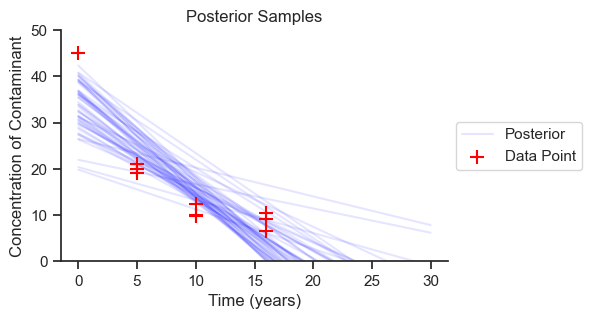

In [25]:
slope = trace_linear.posterior['slope'].values.flatten()
C0 = trace_linear.posterior['C0'].values.flatten()
fig, ax = plt.subplots(figsize=(5,3))
for i in range(50):
    ax.plot(ts, C0[i] + slope[i]*ts, color='blue', alpha=.1, label='Posterior')
ax.set_xlabel('Time (years)')
ax.set_ylabel('Concentration of Contaminant')
ax.set_ylim(0, 50)
ax.scatter(data.Year, data.Concentration, marker='+', s=100, label = 'Data Point', 
         color='red', zorder=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:], loc='center left', bbox_to_anchor=(1,.5))
ax.set_title('Posterior Samples');

We can see how the linear model is a poor fit to the data, and would predict negative concentrations in year 30!  

`az.compare` implements leave-one-out cross validation for the models, then ranks them in order of best performing to worst performing.

In [26]:
compare = az.compare({'SEDCAM':trace, 'Linear':trace_linear})
compare[['rank', 'weight', 'loo', 'p_loo']].round(1)

C:\Users\greg\.conda\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
C:\Users\greg\.conda\envs\pymc_env\lib\site-packages\arviz\stats\stats.py:812: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,weight,loo,p_loo
SEDCAM,0,1.0,-21.1,3.0
Linear,1,0.0,-36.9,4.4


*Bayesian Modeling and Computation in Python* [Section 2.5](https://bayesiancomputationbook.com/markdown/chp_02.html) goes into more detail on the metrics provided by Arviz.  I'll briefly discuss several here.   

The conclusion of the model comparison can be summed up by the rank and the weight.  The rank column orders the models from best to worst.  The weight provides an optimal weight that would be assigned to each model if they were combined into an ensemble model.  Based on these weights the linear model is worthless compared to the SEDCAM model. 

I've included two additional metrics, `loo`, and `p_loo`, which are the basis for the ranks and weights.  `loo` is the leave-out-out expected log pointwise predictive density which evaluates the accuracy of the model with penalties for overfitting.  A higher score is better.  `p_loo` can be generally thought of as the estimated effective number of parameters in the model.  It is interesting to see that the SEDCAM model, which has more parameters than the linear model, has fewer effective parameters. This shows that the structure of the SEDCAM model better describes the data (fewer parameters mean that the model is parsimonious and less likely to overfit).

The `az.comparison` function throws an error message that the models may not be robust to highly influential observations.  This is likely due to the small size of the observed dataset, rather than a model misspecification.   

## Next Steps
This notebook runs through the components of a Bayesian analysis for environmental science following *Bayesian Analysis Reporting Guidelines* in [(Kruschke, 2021)](https://www.nature.com/articles/s41562-021-01177-7).  I hope this is a useful example for Bayesians and non-Bayesians as Bayesian techniques become more commonplace.  The next notebooks will present example models that generally follow this template.